# Tutorial 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sparse/Dense Word embeddings, Embedding visualization

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

## PART 0 ($\sim$5 mins)
*   Downloading a **dataset**.
*   Encoding a a **dataset**.

## PART I ($\sim$30 mins)
*   Building a **vocabulary**.
*   Building a **word-word co-occurrence matrix**.
*   Defining a **similarity metric**: cosine similarity.
*   Embedding **visualization** and **analysis** of their semantic properties.

## PART II ($\sim$30 mins)

*   Loading pre-trained **dense** word embeddings: Word2Vec, GloVe, FastText.
*   Checking **out-of-vocabulary** (OOV) terms.
*   **Handling** OOV terms.

## Preliminaries

First of all, we need to import some useful packages that we will use during this hands-on session.

In [1]:
!pip install simplejson
!pip install umap-learn
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00


In [2]:
# system packages
from pathlib import Path
import shutil
import urllib
import tarfile
import sys

# data and numerical management packages
import pandas as pd
import numpy as np
import simplejson as sj

# useful during debugging (progress bars)
from tqdm import tqdm

# typing
from typing import List, Callable, Dict
from collections import OrderedDict

In [3]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 2560,
        'height': 1440,
        'scroll': True,
})

{'width': 2560, 'height': 1440, 'scroll': True}

# Data

We will use the IMDB dataset first introduced in tutorial 1.

* [**Stats**] A dataset of 50k sentences used for sentiment analysis: 25k with positive sentiment, 25k with negative one.
* [**Labels**] We ignore sentiment labels since we focus on learning a proper word embedding representation.

We start by **downloading** the dataset and **extract** it to a folder.

In [4]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    print("Extraction completed!")

In [5]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_name = "aclImdb"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_tar_path = dataset_folder.joinpath("Movies.tar.gz")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_tar_path.exists():
    download_dataset(dataset_tar_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_tar_path, dataset_folder)

Current work directory: /content


aclImdb_v1.tar.gz: 84.1MB [00:15, 5.39MB/s]                            


Download complete!
Extracting dataset... (it may take a while...)
Extraction completed!


#### Data Inspection

Feel free to check the dataset folder content!

Usually, the README file is a good starting point (if it exists and it is informative -- which is not so common!).

#### Data Format

Just like in the first assignment, we need a **high level view** of the dataset that is helpful to our needs.

We encode the dataset into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [6]:
dataframe_rows = []

for split in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        folder = dataset_folder.joinpath(dataset_name, split, sentiment)
        for file_path in folder.glob('*.txt'):
            with file_path.open(mode='r', encoding='utf-8') as text_file:
                text = text_file.read()
                score = file_path.stem.split("_")[1]
                score = int(score)
                file_id = file_path.stem.split("_")[0]

                num_sentiment = 1 if sentiment == 'pos' else 0

                dataframe_row = {
                    "file_id": file_id,
                    "score": score,
                    "sentiment": num_sentiment,
                    "split": split,
                    "text": text
                }

                dataframe_rows.append(dataframe_row)

In [7]:
folder = Path.cwd().joinpath("Datasets", "Dataframes", dataset_name)
if not folder.exists():
    folder.mkdir(parents=True)

# transform the list of rows in a proper dataframe
df = pd.DataFrame(dataframe_rows)
df = df[["file_id",
         "score",
         "sentiment",
         "split",
         "text"]
       ]
df_path = folder.with_name(dataset_name + ".pkl")
df.to_pickle(df_path)

Let's inspect some major details of the dataset as follows.

In [8]:
print(f"Dataset size: {df.shape}") # (50000, 5)
print(f"Dataset columns: {df.columns.values}") # ['file_id', 'score', 'sentiment', 'split', 'text]
print(f"Classes distribution:\n{df.sentiment.value_counts()}") # [0: 25000, 1: 25000]
print(f"Some examples: {df.iloc[:5]}")

Dataset size: (50000, 5)
Dataset columns: ['file_id' 'score' 'sentiment' 'split' 'text']
Classes distribution:
sentiment
1    25000
0    25000
Name: count, dtype: int64
Some examples:   file_id  score  sentiment  split  \
0    4163      9          1  train   
1   10942      9          1  train   
2    5978      9          1  train   
3   11984     10          1  train   
4    8811      7          1  train   

                                                text  
0  I saw this as a child in the late eighties and...  
1  I would give this show a ten out of ten if it ...  
2  This is a true "80's movie": Back then they ma...  
3  I have never seen a show as good as Full House...  
4  Eleven different Film Makers from different pa...  


# PART I
*   Building a **vocabulary**.
*   Building a **word-word co-occurrence matrix**.
*   Defining a **similarity metric**: cosine similarity.
*   Embedding **visualization** and **analysis** of their semantic properties.

## 1. Building a vocabulary

We consider words as the atomic units for text representation: each word will be associated with a numeric representation.

At this point we can build the word vocabulary of our dataset. This information is the first step of any word embedding method: we need to know the set of atomic entities that build up our corpus.

**Definition**: a vocabulary is a collection of words occurring in a given dataset. More precisely, each word is recognized and assigned to an index.

**Example**: Suppose you have the given toy corpus $D$: { "the cat is on the table" }

As you notice, the dataset is comprised of only one sentence: "the cat is on the table". The corresponding vocabulary (a possible one) will be:

V = {0: 'the', 1: 'cat', 2: 'is', 3: 'on', 4: 'table'}

In this case, indexing follows word order, but it is not mandatory!

### Note 1

The most important thing to remember is that the vocabulary **should always be the same one**.

$\rightarrow$ Thus, make sure that the vocabulary creation routine always returns the same result!

### Note 2

A vocabulary is **exclusively defined** by the tokenization step you define!

$\rightarrow$ Characters, sub-words, words are examples of granularity levels.

### 1.1 Text pre-processing

Before vocabulary creation, we have to do a little bit of **text pre-processing** so as to avoid spurious data.

$\rightarrow$ Data quality is one of the crucial factors that lead to better performance.

$\rightarrow$ Models, even state-of-the-art ones, hardly achieve satisfying results if the dataset is very noisy.

**Types of pre-processing**: there are a lot of pre-processing steps that we can consider, either general or quite task- specific.

*    **Text to lower**: casing usually doesn't affect our task, but in some scenarios, such as part-of-speech tagging, it is crucial.

*    **Replace special characters**: special characters are usually employed as variants of a single character like the spacing symbol ' '. In other cases (dates, etc..) special characters might have a specific meaning and should not be replaced.

*    **Text stripping**: it is important to filter out extra spaces to avoid unwanted distinctions between identical words, such as 'apple' and ' apple '.

There are a lot of pre-processing techniques, such as number replacing, lemmatization, stemming, spell correction, acronyms merge and so on.

$\rightarrow$ If you are interested you can check [here](https://medium.com/swlh/text-normalization-7ecc8e084e31) and [here](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html) some good blogs about the topic.

In [9]:
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def replace_br(text: str) -> str:
    """
    Replaces br characters
    """
    return text.replace('br', '')

In [11]:
def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the good symbols list (check regular expression)
    """
    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    """
    return text.strip()

In [12]:
PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          replace_br,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [13]:
print('Pre-processing text...')

print()
print(f'[Debug] Before:\n{df.text.values[50]}')
print()

# Replace each sentence with its pre-processed version
df['text'] = df['text'].apply(lambda txt: text_prepare(txt))

print(f'[Debug] After:\n{df.text.values[50]}')
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
In 1983, Director Brian De Palma set out to make a film about the rise and fall of an American gangster, and that he did-- with the help of a terrific screenplay by Oliver Stone and some impeccable work by an outstanding cast. The result was `Scarface,' starring Al Pacino in one of his most memorable roles. The story begins in May of 1980, when Castro opened the harbor at Mariel, Cuba, to allow Cuban nationals to join their families in the United States. 125,000 left Cuba at that time, for the greener pastures of freedom in America, and most were honest, hard-working people, thankful for the opportunity they had been granted. But not all. Among the `Marielitos' who streamed into Florida, approximately 25,000 had criminal records and were nothing less than the dregs of Cuba's jails-- criminals considered beyond redemption, who Castro had merely wanted to be rid of. And they, too, saw America as a land of opportunity, even as Al Capone had consider

### 1.2 Vocabulary Creation

Since the text has been pre-processed, space splitting should work correctly. <br>

We proceed on building the vocabulary and perform some sanity checks.

$\rightarrow$ Bare in mind that some packages offers tools for automatic vocabulary creation, such as Keras (check [keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)).

**Note**: In this case, the vocabulary will start from index equal to 1, since the 0 slot is reserved to padding token.

In [14]:
def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    curr_idx = 0
    for sentence in tqdm(df.text.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [15]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(df)
print()
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')
print(f'[Debug] Some words: {[(idx_to_word[idx], idx) for idx in np.arange(10) + 1]}')

100%|██████████| 50000/50000 [00:01<00:00, 35798.98it/s]


[Debug] Index -> Word vocabulary size: 152534
[Debug] Word -> Index vocabulary size: 152534
[Debug] Some words: [('child', 1), ('late', 2), ('eighties', 3), ('must', 4), ('say', 5), ('galaxy', 6), ('express', 7), ('one', 8), ('films', 9), ('sticks', 10)]


In [16]:
def evaluate_vocabulary(idx_to_word: Dict[int, str], word_to_idx: Dict[str, int],
                        word_listing: List[str], df: pd.DataFrame, check_default_size: bool = False):
    print("[Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("[Vocabulary Evaluation] Content checking...")
    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("[Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    print("[Vocabulary Evaluation] Toy example checking...")
    toy_df = pd.DataFrame.from_dict({
        'text': ["all that glitters is not gold", "all in all i like this assignment"]
    })
    _, _, toy_word_listing = build_vocabulary(toy_df)
    toy_valid_vocabulary = set(' '.join(toy_df.text.values).split())
    assert set(toy_word_listing) == toy_valid_vocabulary

In [17]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df)
print("Evaluation completed!")

Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 152534/152534 [00:00<00:00, 1094772.27it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 50000/50000 [00:01<00:00, 37324.85it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 13378.96it/s]

Evaluation completed!


### Note
Define **intermediary tests** for your code in order to inspect data and to assess the correctness of your code!

$\rightarrow$ You don't want to **re-run** huge and time-consuming experiments due to early pipeline errors!

### 1.3 Saving the vocabulary

Generally speaking, it is a good idea to save the dictionary in clear format.

$\rightarrow$ In this way you can quickly check for errors or useful words.

In this case, we will save the vocabulary dictionary in **JSON format**.

In [18]:
vocab_path = Path.cwd().joinpath('Datasets', "aclImdb", 'vocab.json')

print(f"Saving vocabulary to {vocab_path}")
with vocab_path.open(mode='w') as f:
    sj.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to /content/Datasets/aclImdb/vocab.json
Saving completed!


#### Homework 📖

Spend some time at checking the built vocabulary!

In many tasks (e.g., sequential tagging, embedding analysis, etc...), the way text is tokenized is crucial!

In [19]:
import spacy
import random

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Sequential tagging function with POS and NER tagging
def tag_vocabulary_sample(vocab, sample_size=10):
    # Randomly sample words from the vocabulary
    sample_vocab = random.sample(list(vocab), min(sample_size, len(vocab)))

    # Dictionary to store tagged words
    tagged_vocab = {}

    for word in sample_vocab:
        doc = nlp(word)
        for token in doc:
            # Get POS tag
            pos_tag = token.pos_

            # Get Named Entity tag (if any)
            entity_tag = token.ent_type_ if token.ent_type_ else "O"  # "O" for no entity

            # Save POS and NER tags
            tagged_vocab[word] = {
                "POS": pos_tag,
                "Entity": entity_tag
            }

    return tagged_vocab

# Assuming word_to_idx is your vocabulary dictionary
sample_tagged_vocab = tag_vocabulary_sample(word_to_idx.keys(), sample_size=10)

# Print the tagged sample vocabulary
print("Sample tagged vocabulary with POS and NER:")
for word, tags in sample_tagged_vocab.items():
    print(f"{word}: POS={tags['POS']}, Entity={tags['Entity']}")


Sample tagged vocabulary with POS and NER:
luv: POS=PROPN, Entity=O
amar: POS=PROPN, Entity=GPE
recentlyfired: POS=VERB, Entity=O
barfuss: POS=ADJ, Entity=O
scots: POS=NOUN, Entity=O
reworded: POS=VERB, Entity=O
languishes: POS=VERB, Entity=O
strafe: POS=ADJ, Entity=O
stroppy: POS=ADJ, Entity=O
confessions: POS=NOUN, Entity=O


## 2. Sparse embeddings

Working with text inherently requires a numerical conversion step, known as **embedding**.

**Bag-of-Words (BoW)**
1.   Count the occurrence of each word in a given corpus
2.   Build a word co-occurrence matrix: useful to identify the most common terms in each given document.

This type of reasoning is directly related to **how meaning is assigned to words**.

$\rightarrow$  In particular, it is the environment enclosing a word that gives a specific meaning to it.

$\rightarrow$  Thus, we look for numerical encoding methods that reflect such point of view.

### 2.1 A quick simplification

Since the dataset is quite large, the co-occurrence matrix construction may take a while or may require efficient solutions.

For the purpose of this tutorial, we can rely on a **small slice** of the dataset.

$\rightarrow$ Nonetheless, feel free to work with the whole dataset! Suggestions on how to handle this scenario are
given below when required.

In [20]:
# This type of slicing is not mandatory, but it is sufficient to our purposes
np.random.seed(42)

random_indexes = np.random.choice(np.arange(df.shape[0]),
                                  size=1000,
                                  replace=False)

df = df.iloc[random_indexes]
print(f'New dataset size: {df.shape}')
idx_to_word, word_to_idx, word_listing = build_vocabulary(df)

New dataset size: (1000, 5)


100%|██████████| 1000/1000 [00:00<00:00, 20812.00it/s]


### 2.2 Building the Co-occurence Matrix

For each word in the vocabulary we count the number of times each other word appears within the same context window.

Let's define the simplest version of a **co-occurrence matrix** based on word counting.

### Small dataset case
You should have a vocabulary size that we can afford in terms of memory demand.

$\rightarrow$ You can easily instantiate the co-occurrence matrix and populate it iteratively.

### Large dataset case
We have to work with sparse matrices due to the high vocabulary size and to the low amount of non-zero word counts.

$\rightarrow$ The [Scipy package](https://docs.scipy.org/doc/scipy/reference/sparse.html) allows us to easily define sparse matrices that can be converted ot numpy arrays.

**Suggestion**: The simplest way to build the co-occurrence matrix is via an incremental approach:
1. Loop through dataset sentences
2. Split into words
3. Count co-occurrences within the given window frame.

Combining this approach with sparse matrices is not so efficient (yet possible). However, Scipy offers [$\texttt{lil_matrix}$](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix) sparse format that is suitable to this case.

You can check out other sparse formats, such as [$\texttt{csr_matrix}$](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix), and the corresponding building methods.

Working with $\texttt{lil_matrix}$ might take $\sim 1h$ of time to build the whole dataset co-occurrence matrix. It is also possibile to work with $\texttt{csr_matrix}$ but the approach is more complex (check the last example of the corresponding documentation page).

In [21]:
import zipfile
import gc
import requests
import time

def co_occurrence_count(df: pd.DataFrame,
                        idx_to_word: Dict[int, str],
                        word_to_idx: Dict[str, int],
                        window_size: int = 4) -> np.ndarray:
    """
    Builds word-word co-occurrence matrix based on word counts.

    :param df: pre-processed dataset (pandas.DataFrame)
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)

    :return
      - co_occurrence symmetric matrix of size |V| x |V| (|V| = vocabulary size)
    """
    vocab_size = len(idx_to_word)
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

    for sentence in tqdm(df.text.values):
        tokens = sentence.split()
        for pos, token in enumerate(tokens):
            start = max(0, pos - window_size)
            end = min(pos + window_size + 1, len(tokens))

            first_word_index = word_to_idx[token]

            for pos2 in range(start, end):
                if pos2 != pos:
                    second_token = tokens[pos2]
                    second_word_index = word_to_idx[second_token]
                    co_occurrence_matrix[first_word_index, second_word_index] += 1

    return co_occurrence_matrix

In [22]:
# Clean RAM before re-running this code snippet to avoid possible session crash
if 'co_occurrence_matrix' in globals():
    del co_occurrence_matrix
    gc.collect()
    time.sleep(10.)     # Give colab some time

print("Building co-occurrence count matrix... (it may take a while...)")
co_occurrence_matrix = co_occurrence_count(df, idx_to_word, word_to_idx, window_size=4)
print("Building completed!")

Building co-occurrence count matrix... (it may take a while...)


100%|██████████| 1000/1000 [00:04<00:00, 239.59it/s]

Building completed!


### 2.3 Embedding Visualization

The next step is to visualize our sparse word embeddings in a lower dimensional space (2D) in order to have an idea of the meaning attributed to each word.

**How?** We will explore SVD, t-SNE methods, and Umap, without delving into technical details since they are not arguments of this NLP course.

**SVD Memo**: SVD stands for **Singular Value Decomposition** and is a kind of generalized **Principal Components Analysis** (PCA) and focuses on selecting the top **k** principal components. For more info, [here](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf) you can find a brief tutorial.

**t-SNE Memo**: t-SNE stands for **t-Distributed Stochastic Neighbour Embedding** and is an unsupervised non-linear technique.
* It preserves small pairwise distance (or local similarities), whereas PCA aims to preserve large pairwise distances in order to maximize variance.
* The basic idea of t-SNE is to compute a similarity measure between a pair of instances both at high and low dimensional space and optimize these two similarities via a cost function.
* Properly using t-SNE is a bit tricky, a well recommended reading is one of the [author's blog](https://lvdmaaten.github.io/tsne/).

**UMAP Memo**: UMAP stands for **Uniform Manifold Approximation and Projection for Dimensionality Reduction** and is an unsupervised non-linear technique like t-SNE.

* **Faster** than t-SNE
* **More accurate** than t-SNE in terms of data's global structure preservation
* Informally constructs a high-dimensional graph representation of the data and then optimizes a low-dimensional graph to be as structurally similar as possibile
* Check this [blog](https://pair-code.github.io/understanding-umap/) if you are interested!

#### Homework 📖

Play with the **window size** and check if there are some notable differences. <br>

Generally:
* Small window size $\rightarrow$ reflects syntactic properties.
* Large window size $\rightarrow$ captures semantic ones.

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import umap
import matplotlib.pyplot as plt

In [24]:
def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

    :param embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
    :param word_annotations: list of words to be annotated.
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # We avoid outliers ruining the visualization if they are quite far away
    axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
    axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
    plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
    plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
    ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
    ax.set_ylim(axis_y_limit[0], axis_y_limit[1])

In [25]:
def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies SVD dimensionality reduction.

    :param embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    :return
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    print("Running SVD reduction method...")
    svd = TruncatedSVD(n_components=2, n_iter=10)
    reduced = svd.fit_transform(embeddings)
    print("SVD reduction completed!")

    return reduced

def reduce_tSNE(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies t-SNE dimensionality reduction.
    """
    print("Running t-SNE reduction method... (it may take a while...)")
    tsne = TSNE(n_components=2, n_iter=1000, metric='cosine')
    reduced = tsne.fit_transform(embeddings)
    print("t-SNE reduction completed!")

    return reduced

def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies UMAP dimensionality reduction.
    """
    print("Running UMAP reduction method... (it may take a while...)")
    umap_emb = umap.UMAP(n_components=2, metric='cosine')
    reduced = umap_emb.fit_transform(embeddings)
    print("UMAP reduction completed!")

    return reduced

In [26]:
# Feel free to play with word_annotations argument!
# Check the saved dictionary!
def run_visualization(method_name: str,
                      words_list: List[str],
                      word_to_idx: Dict[str, int],
                      co_occurrence_matrix):
    method_name = method_name.lower().strip()
    method_map = {
        'svd': reduce_SVD,
        'tsne': reduce_tSNE,
        'umap': reduce_umap
    }

    if method_name not in method_map:
        raise RuntimeError(f'Invalid method name! Got {method_name}.')

    reduced = method_map[method_name](co_occurrence_matrix)
    visualize_embeddings(reduced, words_list, word_to_idx)

Running UMAP reduction method... (it may take a while...)
UMAP reduction completed!
Annotating words: ['good', 'love', 'beautiful']


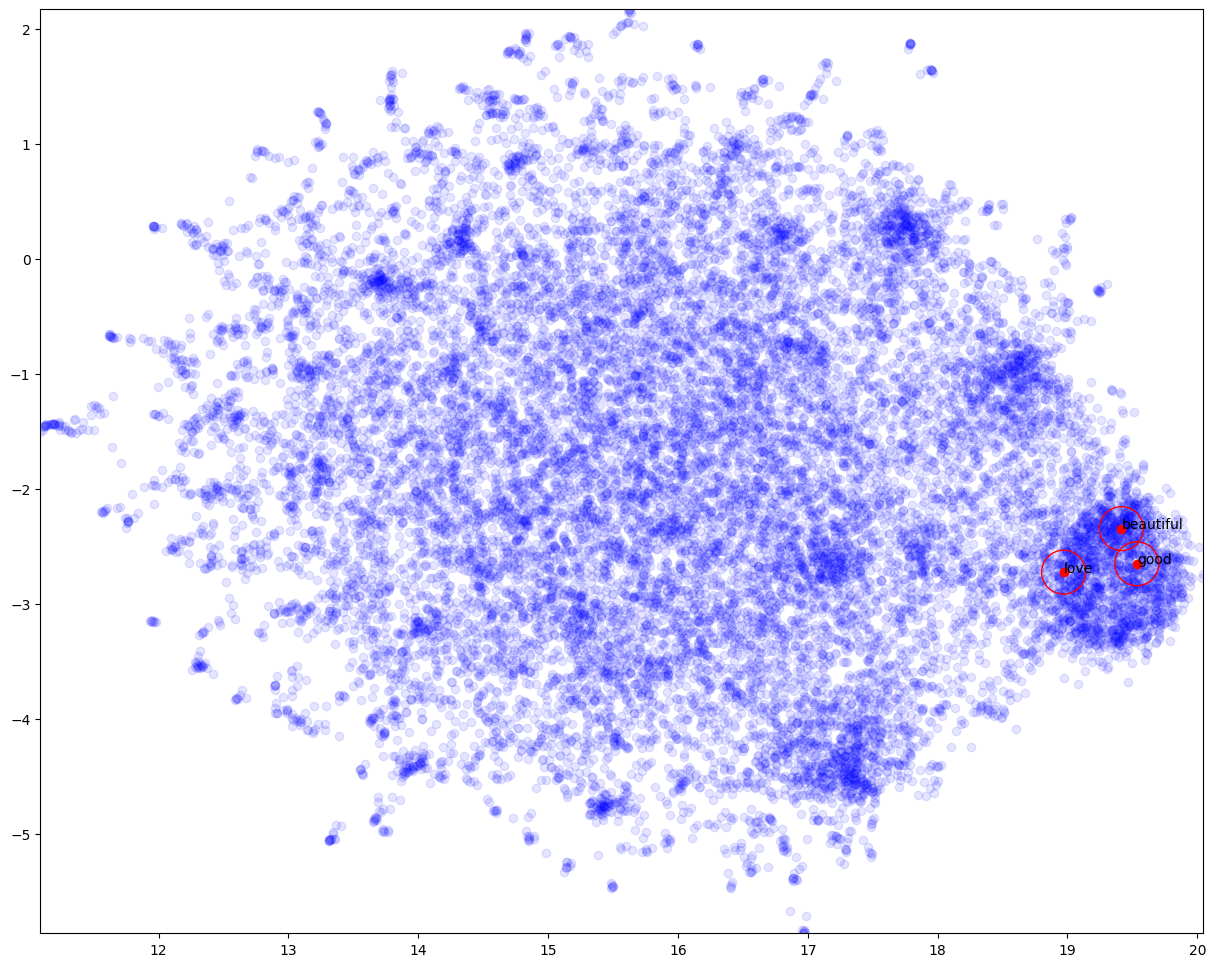

In [27]:
# 'umap', 'tsne', 'svd'
run_visualization('umap', ['good', 'love', 'beautiful'], word_to_idx, co_occurrence_matrix)
plt.show()

#### Homework 📖

Play with different dimension reduction techniques.

Note that these techniques are very sensitive to some of their hyper-parameters!

Running SVD reduction method...
SVD reduction completed!
Annotating words: ['good', 'love', 'beautiful']


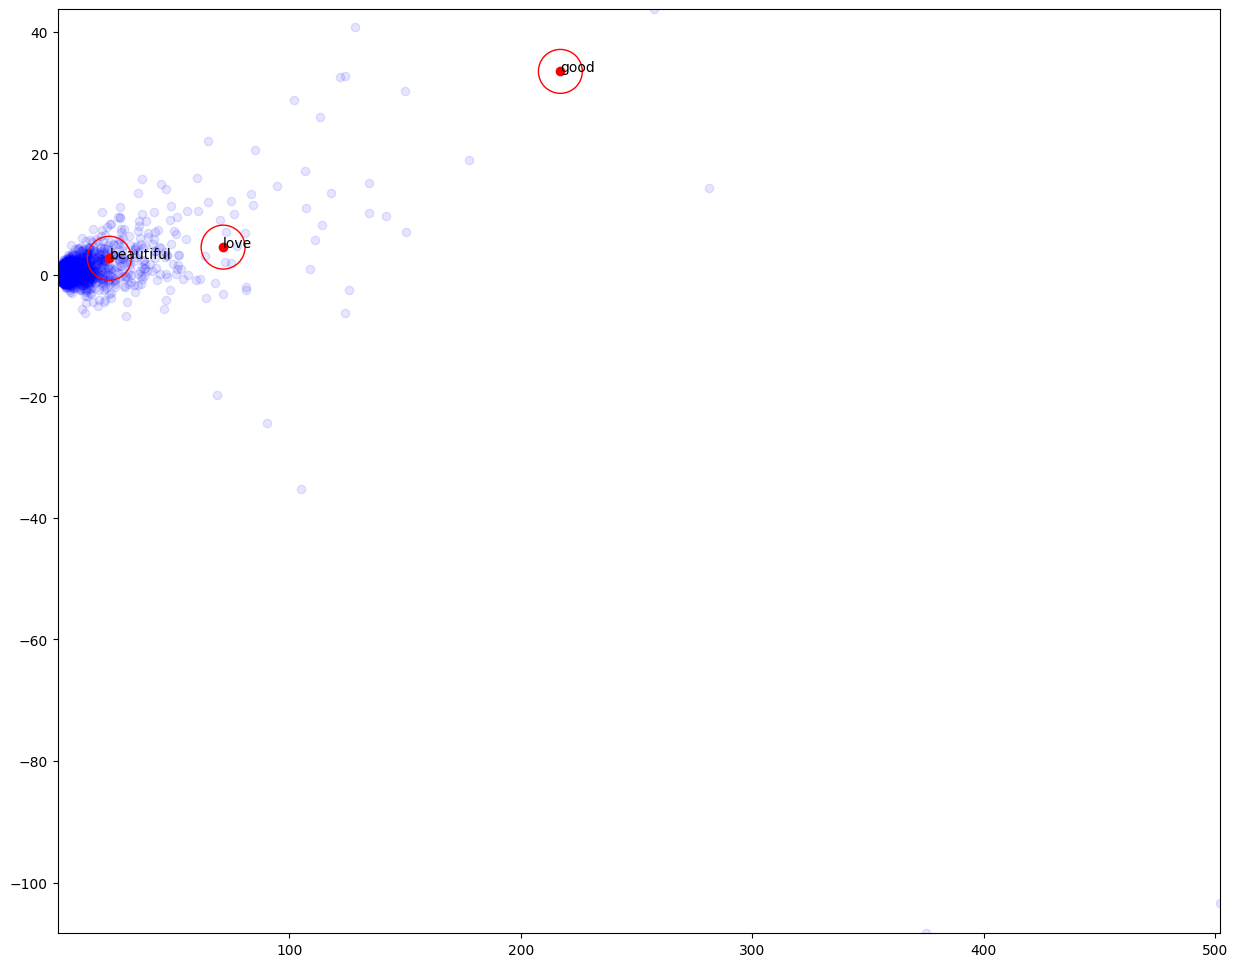

In [28]:
# 'umap', 'tsne', 'svd'
run_visualization('svd', ['good', 'love', 'beautiful'], word_to_idx, co_occurrence_matrix)
plt.show()

In [29]:
# 'umap', 'tsne', 'svd'
run_visualization('tsne', ['good', 'love', 'beautiful'], word_to_idx, co_occurrence_matrix)
plt.show()

Running t-SNE reduction method... (it may take a while...)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 

### 2.4 Embedding properties

Visualization can give us a rough idea of how word embeddings are organized and if some semantic properties are reflected in the numerical dimensional space.

$\rightarrow$ For example, are synonyms close together? Ideally, if the dataset is big enough, we should see similar vector embeddings since synonyms usually have similar contexts.

##### How to do that?
We could highlight target words in the visualization step and check if our expectations are met. For instance, synonyms should be close together.

**However**, this method is rather **inaccurate** and **time-consuming** (dimensionality reduction is not a perfect mapping).

$\rightarrow$ We need some sort of similarity metric that is independent of the vector dimensionality.

### 2.5 Cosine Similarity

We want to measure how two word vectors are far apart.

#### Naive Method

A naive solution would involve computing the dot product of the two vectors.

However, this metric will give higher similarity either to longer vectors or to vectors that have higher counts.

#### Cosine Similarity

A better metric is **cosine similarity** which is just a normalized dot product.

\begin{align}
s(p, q) = \frac{p \, \cdot \, q}{||p|| \, \cdot \, ||q||}
\end{align}

where $s(p, q) \in [-1, 1] $, since it computes the cosine of the angle between the two vectors.

Intuitively, we are bringing vectors down to the d-dimensional unit sphere (d is the vocab size) and then computing their distance (in 2D space we will have a circle).

In [30]:
from sklearn.metrics.pairwise import cosine_similarity as sk_cs

def cosine_similarity(p: np.ndarray,
                      q: np.ndarray,
                      transpose_p: bool = False,
                      transpose_q: bool = False) -> np.ndarray:
    """
    Computes the cosine similarity of two d-dimensional matrices

    :param p: d-dimensional vector (np.ndarray) of shape (p_samples, d)
    :param q: d-dimensional vector (np.ndarray) of shape (q_samples, d)
    :param transpose_p: whether to transpose p or not
    :param transpose_q: whether to transpose q or not

    :return
        - cosine similarity matrix S of shape (p_samples, q_samples)
          where S[i, j] = s(p[i], q[j])
    """
    if len(p.shape) == 1:
        p = p.reshape(1, -1)
    if len(q.shape) == 1:
        q = q.reshape(1, -1)

    return sk_cs(p.T if transpose_p else p, q.T if transpose_q else q)

similarity_matrix = cosine_similarity(co_occurrence_matrix,
                                      co_occurrence_matrix)

### 2.6 [Let's play] Analogies, Bias, Synonyms and Antonyms

Let's look for some words and provide a possible explanation of achieved results according to cosine similarity metric.

* Synonym pair: (w1, w2) such that w1 and w2 are synonyms
* Antonyms pair: (w1, w2) such that w1 and w2 are antonyms
* Synonym-Antonym triplet: (w1, w2, w3) such that w1 and w2 are synonyms and w1 and w3 are antonyms

#### Analogy

Another useful property to check is analogy resolution via word vectors.

In particular, we might want to check if analogies such "man : king == woman : x" bring results like "x = queen".

In order to do so, we first need to define a ranking function that returns the top $K$ most similar words of a given word vector.

$\rightarrow$ We might not want to be too much restrictive and play with $K \ge 1$.

In [31]:
from itertools import product

def show_similarity_for_nary(words: List[str],
                             similarity_matrix: np.ndarray,
                             word_to_idx: Dict[str, int],
                             idx_to_word: Dict[int, str]):
    """
    Shows similarity values for each pair of input words.

    :param words: a list of candidate words.
    :param similarity_matrix: np.ndarray containing similarity values
    between each vocabulary word pair
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)

    """
    word_indexes = [word_to_idx[word] for word in words]
    similarity_dict = {}

    for comb in product(word_indexes, word_indexes):
        similarity_value = similarity_matrix[comb[0], comb[1]]
        similarity_dict.setdefault(comb[0], []).append(similarity_value)

    similarity_df = pd.DataFrame.from_dict(similarity_dict)
    similarity_df.columns = [idx_to_word[col] for col in similarity_df.columns]
    similarity_df.index = similarity_df.columns
    similarity_df = similarity_df.transpose()
    print(F'Similarity values: \n{similarity_df}')

In [32]:
show_similarity_for_nary(['film', 'movie'], similarity_matrix, word_to_idx, idx_to_word)
show_similarity_for_nary(['good', 'bad'], similarity_matrix, word_to_idx, idx_to_word)
show_similarity_for_nary(['good', 'well', 'bad'], similarity_matrix, word_to_idx, idx_to_word)

Similarity values: 
           film     movie
film   1.000000  0.872209
movie  0.872209  0.999999
Similarity values: 
          good       bad
good  1.000000  0.858054
bad   0.858054  1.000001
Similarity values: 
          good      well       bad
good  1.000000  0.790253  0.858054
well  0.790253  1.000000  0.740855
bad   0.858054  0.740855  1.000001


In [33]:
def get_top_K_indexes(data: np.ndarray, K: int) -> np.ndarray:
    """
    Returns the top K indexes of a 1-dimensional array (descending order)
    Example:
        data = [0, 7, 2, 1]
        best_indexes:
        K = 1 -> [1] (data[1] = 7)
        K = 2 -> [1, 2]
        K = 3 -> [1, 2, 3]
        K = 4 -> [1, 2, 3, 4]

    :param data: 1-d dimensional array
    :param K: number of highest value elements to consider

    :return
        - array of indexes corresponding to elements of highest value
    """
    best_indexes = np.argsort(data, axis=0)[::-1]
    best_indexes = best_indexes[:K]

    return best_indexes

In [34]:
def get_top_K_word_ranking(embedding_matrix: np.ndarray, idx_to_word: Dict[int, str],
                           word_to_idx: Dict[str, int],  positive_listing: List[str],
                           negative_listing: List[str],  K: int) -> (List[str], np.ndarray):
    """
    Finds the top K most similar words following this reasoning:
        1. words that have highest similarity to words in positive_listing
        2. words that have highest distance to words in negative_listing

    :param embedding_matrix: embedding matrix of shape (words, embedding dimension).
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param positive_listing: list of words that should have high similarity with top K retrieved ones.
    :param negative_listing: list of words that should have high distance to top K retrieved ones.
    :param K: number of best word matches to consider

    :return
        - top K word matches according to aforementioned criterium
        - similarity values of top K word matches according to aforementioned criterium
    """
    # Positive words (similarity)
    positive_indexes = np.array([word_to_idx[word] for word in positive_listing])
    word_positive_vector = np.sum(embedding_matrix[positive_indexes, :], axis=0)

    # Negative words (distance)
    negative_indexes = np.array([word_to_idx[word] for word in negative_listing])
    word_negative_vector = np.sum(embedding_matrix[negative_indexes, :], axis=0)

    # Find candidate words
    target_vector = (word_positive_vector - word_negative_vector) / (len(positive_listing) + len(negative_listing))
    total_indexes = np.concatenate((positive_indexes, negative_indexes))
    valid_indexes = np.setdiff1d(np.arange(similarity_matrix.shape[0]), total_indexes)
    candidate_vectors = embedding_matrix[valid_indexes]

    candidate_similarities = cosine_similarity(candidate_vectors, target_vector)
    candidate_similarities = candidate_similarities.ravel()

    relative_indexes = get_top_K_indexes(candidate_similarities, K)
    top_K_indexes = valid_indexes[relative_indexes]
    top_K_words = [idx_to_word[idx] for idx in top_K_indexes]

    return top_K_words, candidate_similarities[relative_indexes]

In [35]:
"""
    Positive and negative listing can be defined accordingly to a given analogy
    Example:

        man : king :: woman : x

    positive_listing = ['king', 'woman']
    negative_listing = ['man']

    This is equivalent to: compute king - man + woman, and then find the
    most similar candidate.
"""

# Examples
# tv : episodes :: film : x
# masterpiece : superb :: x : tragic
top_K_words, top_K_values = get_top_K_word_ranking(embedding_matrix=co_occurrence_matrix,
                                                   idx_to_word=idx_to_word,
                                                   word_to_idx=word_to_idx,
                                                   positive_listing=['episodes', 'film'],
                                                   negative_listing=['tv'],
                                                   K=10)
print(f'Top K words: {top_K_words}')
print(f'Top K values: {top_K_values}')

Top K words: ['movie', 'one', 'really', 'even', 'good', 'see', 'like', 'story', 'would', 'get']
Top K values: [0.8601327  0.80931175 0.7827748  0.7814554  0.77998424 0.7740562
 0.771399   0.7705274  0.75902885 0.7572004 ]


#### Homework 📖

Take some time to play with different analogies.

**How?** Check the vocabulary and related tokens frequency!

Top 10 most frequent words:
movie: 12528.0
film: 11541.0
one: 7614.0
like: 6584.0
good: 4764.0
even: 4020.0
really: 3907.0
story: 3600.0
would: 3585.0
time: 3576.0


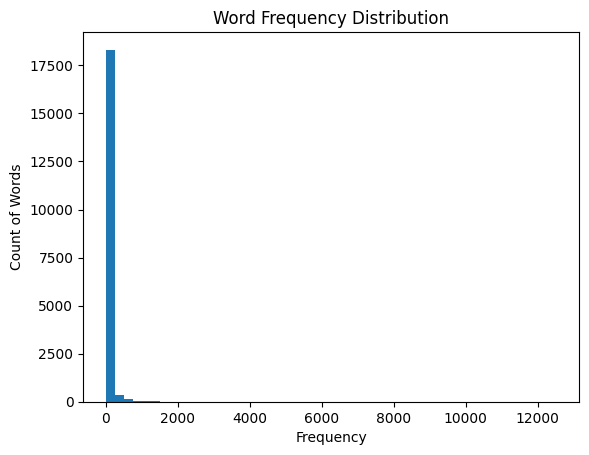

In [36]:
from collections import Counter

def check_token_frequency(word_to_idx, idx_to_word, co_occurrence_matrix):
    """
    Print the frequency of words in the vocabulary based on their occurrence in the co-occurrence matrix.

    :param word_to_idx: dictionary mapping words to indices
    :param idx_to_word: dictionary mapping indices to words
    :param co_occurrence_matrix: co-occurrence matrix of words (e.g., word embeddings or word count matrix)

    :return: None
    """
    # Get word frequencies based on row sums (or column sums if you're using co-occurrence matrix)
    word_frequencies = np.sum(co_occurrence_matrix, axis=1)

    # Create a frequency dictionary for words
    word_freq_dict = {idx_to_word[idx]: word_frequencies[idx] for idx in range(len(word_frequencies))}

    # Print the most common words
    sorted_word_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

    print("Top 10 most frequent words:")
    for word, freq in sorted_word_freq[:10]:
        print(f"{word}: {freq}")

    # Optionally, you can print out a histogram of word frequencies
    import matplotlib.pyplot as plt
    plt.hist(word_frequencies, bins=50)
    plt.title("Word Frequency Distribution")
    plt.xlabel("Frequency")
    plt.ylabel("Count of Words")
    plt.show()

# Example usage
check_token_frequency(word_to_idx, idx_to_word, co_occurrence_matrix)


In [37]:
def explore_analogy(embedding_matrix: np.ndarray, idx_to_word: Dict[int, str],
                    word_to_idx: Dict[str, int], positive_listing: List[str],
                    negative_listing: List[str], K: int):
    """
    Explores analogies by providing positive and negative word listings.

    :param embedding_matrix: embedding matrix (words x embedding dimension)
    :param idx_to_word: dictionary mapping index -> word
    :param word_to_idx: dictionary mapping word -> index
    :param positive_listing: list of words that should have high similarity with top K retrieved ones
    :param negative_listing: list of words that should have high distance to top K retrieved ones
    :param K: number of top similar words to retrieve
    :return: top K words for the analogy
    """
    top_K_words, top_K_values = get_top_K_word_ranking(
        embedding_matrix=embedding_matrix,
        idx_to_word=idx_to_word,
        word_to_idx=word_to_idx,
        positive_listing=positive_listing,
        negative_listing=negative_listing,
        K=K
    )

    print(f"Top {K} words for the analogy {positive_listing} : {negative_listing} :: X:")
    for word, value in zip(top_K_words, top_K_values):
        print(f"{word}: {value}")

    return top_K_words, top_K_values


In [38]:
# Example 1: Man : King :: Woman : X
positive_listing = ['film', 'tv']
negative_listing = ['home']
top_K_words_1, top_K_values_1 = explore_analogy(
    embedding_matrix=co_occurrence_matrix,
    idx_to_word=idx_to_word,
    word_to_idx=word_to_idx,
    positive_listing=positive_listing,
    negative_listing=negative_listing,
    K=10
)


Top 10 words for the analogy ['film', 'tv'] : ['home'] :: X:
movie: 0.8738482594490051
one: 0.8255425691604614
really: 0.8010367155075073
good: 0.7961717844009399
even: 0.7937158942222595
see: 0.7889379858970642
like: 0.7874431014060974
story: 0.7794042825698853
would: 0.7726808786392212
well: 0.7672023177146912


# PART II

*   Loading pre-trained **dense** word embeddings: Word2Vec, GloVe, FastText.
*   Checking **out-of-vocabulary** (OOV) terms.
*   **Handling** OOV terms.

## 1. Dense embeddings

Until now we've worked with sparse embedding methods, which lead to high dimensional word embeddings (dimension equal to $|V|$).

The **main drawback** of such approach is that words belong to separate dimensions.

$\rightarrow$ We need to have a large corpus available to check if two words have similar contexts.

#### Dense Embedding Technique

To this end, we might prefer a dense embedding technique. <br>
$\rightarrow$ All words are encoded into a high dimensional space, much smaller than $|V|$ (generally up to $\sim 1000$).

A dense representation is also convenient from a machine learning point of view:
*    **Fewer parameters** to learn and, thus, models are less prone to overfitting.
*    Words do not belong to separate dimensions anymore and semantic relationships are easily modelled.

### 1.1 Working with a pre-trained model

The first step consists in choosing and downloading a pre-trained embedding model.

For the purpose of this assignment, we limit to classic models, such as Word2Vec, GloVe and FastText.

Furthermore, some pre-trained embedding model versions may be quite resource demanding, depending on the embedding dimension and on the vocabulary size.

$\rightarrow$ We recommend sticking to low dimensional spaces (50, 100, 200) to avoid being stuck waiting for too much time.

### A Brief Recap

For a full list of available embeddings models, please check [here](https://github.com/RaRe-Technologies/gensim-data).

* **Word2Vec**: the first example of dense word encoding. There are two well-known strategies:
     * Continuous Bag-of-words (CBoW): context words are used to predict a target word.
     * Skip-gram: a target word is used to predict its own context.
* **GloVe**: it is another techniques that tries to encoded global semantic properties based on the co-occurrence matrix. Conversely, word2vec exploits local information.
* **Fasttext**: an extension of word2vec where words are defined as character n-grams. It works very well with rare words contrarily to Word2Vec and GloVe.

In [39]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [40]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300
embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=50)

[==================================================] 100.0% 66.0/66.0MB downloaded


#### Homework 📖

Play with different embedding models and embedding sizes.

Compare the achieved visualizations.

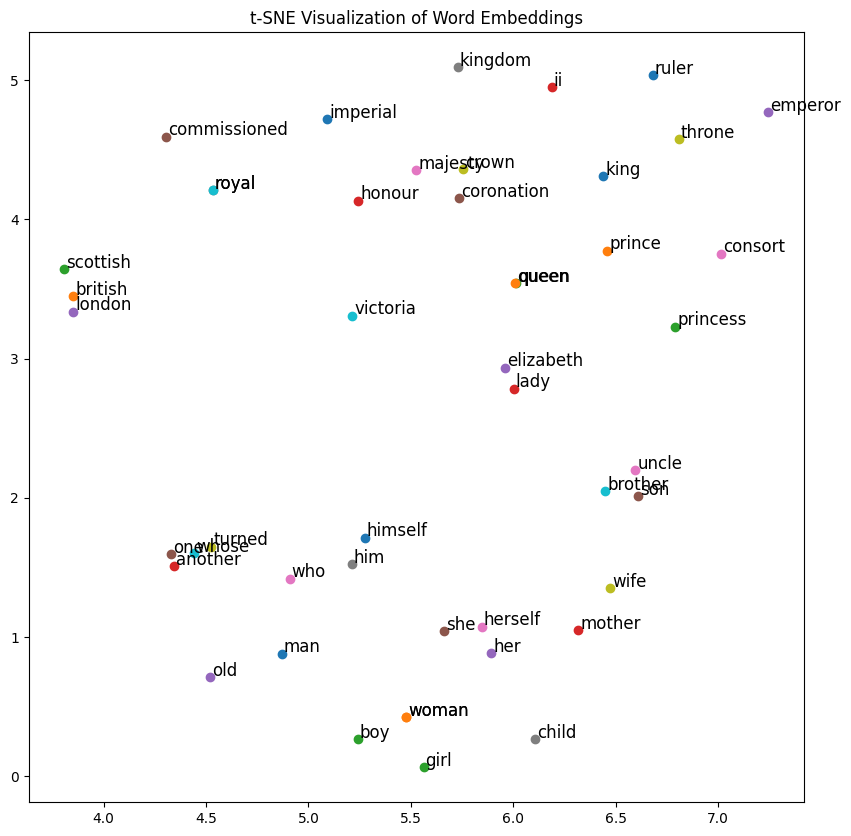

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(model, word_list: List[str], top_n: int = 10):
    """
    Visualizes the top N similar words in a 2D space using t-SNE.

    :param model: The pre-trained word embedding model (Word2Vec, GloVe, or FastText)
    :param word_list: List of words to visualize
    :param top_n: Number of most similar words to retrieve for each word
    """
    word_vectors = []
    words = []

    for word in word_list:
        if word in model.key_to_index:  # Check if the word is in the model's vocabulary
            words.append(word)
            word_vectors.append(model[word])

        # Find the top N similar words
        similar_words = model.most_similar(word, topn=top_n)
        for similar_word, _ in similar_words:
            if similar_word not in words:
                words.append(similar_word)
                word_vectors.append(model[similar_word])

    # Apply t-SNE for 2D visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(np.array(word_vectors))

    # Plot the words in a 2D space
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1])
        plt.text(tsne_results[i, 0] + 0.01, tsne_results[i, 1] + 0.01, word, fontsize=12)

    plt.title("t-SNE Visualization of Word Embeddings")
    plt.show()

# Example of visualization
embedding_model = load_embedding_model("glove", 50)  # Change model and dimension as needed
visualize_embeddings(embedding_model, word_list=['king', 'queen', 'man', 'woman', 'royal'], top_n=10)


[==================================================] 100.0% 958.5/958.4MB downloaded
Visualizing FastText (50) embeddings...


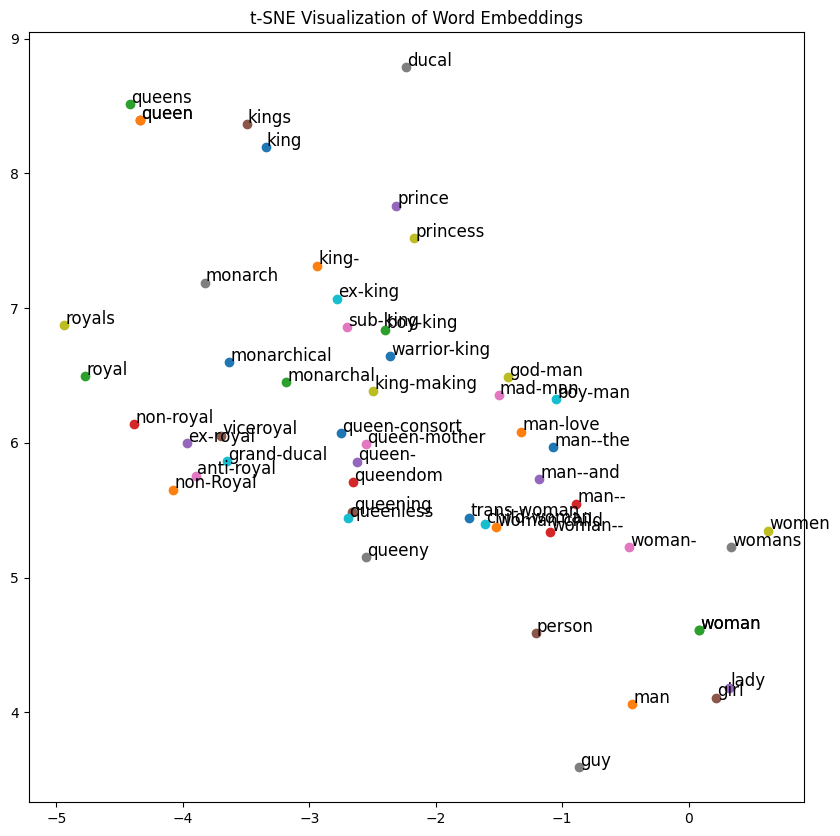

In [45]:
# Visualize for different models and dimensions
# embedding_model_w2v = load_embedding_model("word2vec", 300)
# embedding_model_glove = load_embedding_model("glove", 50)
embedding_model_ft = load_embedding_model("fasttext", 50)

# Visualize the same words with different models
words_to_visualize = ['king', 'queen', 'man', 'woman', 'royal']

# print("Visualizing Word2Vec (300) embeddings...")
# visualize_embeddings(embedding_model_w2v, word_list=words_to_visualize, top_n=10)

# print("Visualizing GloVe (50) embeddings...")
# visualize_embeddings(embedding_model_glove, word_list=words_to_visualize, top_n=10)

print("Visualizing FastText (50) embeddings...")
visualize_embeddings(embedding_model_ft, word_list=words_to_visualize, top_n=10)


### 1.2 Out of vocabulary (OOV) words

Before evaluating pre-trained dense word embeddings, it is good practice to check if the model is consistent with our dataset.

$\rightarrow$ We check the number of out-of-vocabulary (OOV) terms.

If the OOV amount is negligible, we can just keep going. On the other hand, we might want to handle OOV terms by assigning them a specific word vector.

**Which one?** One common practice is to assign a **random vector**, since the embedding model will be part of a deep learning model and, thus, word vectors might be trained during the learning process.

Even if that is the case, we can assign an embedding that is more meaningful rather than a random one.

$\rightarrow$ We can identify the word embedding of an OOV term as the **mean of its neighbour word embeddings**.

In [46]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary) # terms outside the vocabulary
    return list(oov)

In [47]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing) # percentage of oov terms
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 2360 (12.47%)


### 1.3 Handling OOV words

Now we proceed on building the embedding matrix, while handling OOV terms at the same time.

In [48]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [49]:
# Testing
embedding_dimension = 50
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, len(word_to_idx), oov_terms)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 18927/18927 [00:00<00:00, 214295.60it/s]

Embedding matrix shape: (18927, 50)


### 1.4 Embedding visualization (cont'd)

We are now ready to visualize pre-trained word embeddings!

Running UMAP reduction method... (it may take a while...)
UMAP reduction completed!


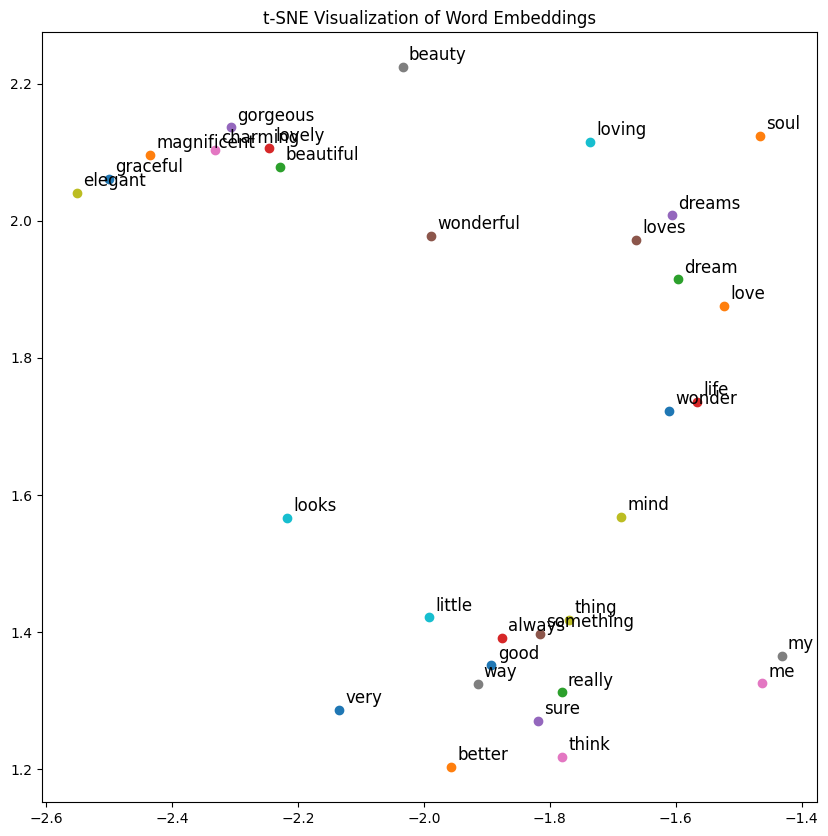

In [52]:
# UMAP
reduced_embedding_umap = reduce_umap(embedding_matrix)
# Pass the original embedding model instead of the reduced embedding matrix:
visualize_embeddings(embedding_model, ['good', 'love', 'beautiful'], 10) # Changed word_to_idx to 10 or any other desired integer for top_n

plt.show()

### 1.5 [Let's play!] Embedding properties (cont'd)

Let's consider some previous examples for quick comparison.

In [53]:
top_K_words, top_K_values = get_top_K_word_ranking(embedding_matrix=embedding_matrix,
                                                   idx_to_word=idx_to_word,
                                                   word_to_idx=word_to_idx,
                                                   positive_listing=['episodes', 'film'],
                                                   negative_listing=['tv'],
                                                   K=10)
print(f'Top K words: {top_K_words}')
print(f'Top K values: {top_K_values}')

Top K words: ['adaptation', 'episode', 'novel', 'films', 'sequel', 'novels', 'screenplay', 'soundtrack', 'cameo', 'drama']
Top K values: [0.78791964 0.7871996  0.7586306  0.74662924 0.73375267 0.7320131
 0.7301122  0.72881866 0.70862806 0.69585866]


#### Homework 📖

Compare word embedding analysis between sparse and dense word embeddings.

# Takeway Messages

#### Teaching

Your TA should be quite thirsty and tired at this point, make sure they are okay even though you didn't understand a single word of their "English". Possibly, offer them a beer 💞.

#### Dense vs Sparse Embeddings

Dense word embeddings are very cool w.r.t. to sparse ones. However, we've just explored fixed embedding models: each word has its own embedding vector independently of the current context.

#### Out-of-vocabulary Terms
OOV terms are everywhere, when we should worry about them? Have a look at pre-trained embedding models if they are suitable to your domain to drastically reduce this issue.

# The End!